In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler





In [345]:
random_state=42

# Cruide Oil WTI 

## 7:3

In [346]:
df= pd.read_csv('../dataset/Crude Oil WTI.csv')


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [347]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [348]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


### Tạo hàm Eval

In [349]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [350]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,55.8
1,56.195
2,56.195
3,56.59
4,56.56
...,...
1787,77.72
1788,79.83
1789,79.23
1790,77.91


### Train, Test


In [351]:
# Split the data into training, testing
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [352]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [353]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [354]:
eval(y_test,y_pred)

** Testing **
MAE:  23.751418397884198
MAPE:  30.83047474746923
RMSE:  25.40321455227303


### Predict

In [355]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [356]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[114.31732595 114.36069745 114.40406895 114.44744046 114.49081196
 114.53418346 114.57755497 114.62092647 114.66429797 114.70766948
 114.75104098 114.79441248 114.83778399 114.88115549 114.92452699
 114.9678985  115.01127    115.0546415  115.09801301 115.14138451
 115.18475601 115.22812752 115.27149902 115.31487052 115.35824203
 115.40161353 115.44498503 115.48835654 115.53172804 115.57509954]
Predicted closing prices for the next 60 days:
[115.61847105 115.66184255 115.70521405 115.74858556 115.79195706
 115.83532856 115.87870006 115.92207157 115.96544307 116.00881457
 116.05218608 116.09555758 116.13892908 116.18230059 116.22567209
 116.26904359 116.3124151  116.3557866  116.3991581  116.44252961
 116.48590111 116.52927261 116.57264412 116.61601562 116.65938712
 116.70275863 116.74613013 116.78950163 116.83287314 116.87624464]
Predicted closing prices for the next 90 days:
[116.91961614 116.96298765 117.00635915 117.04973065 117.09310216

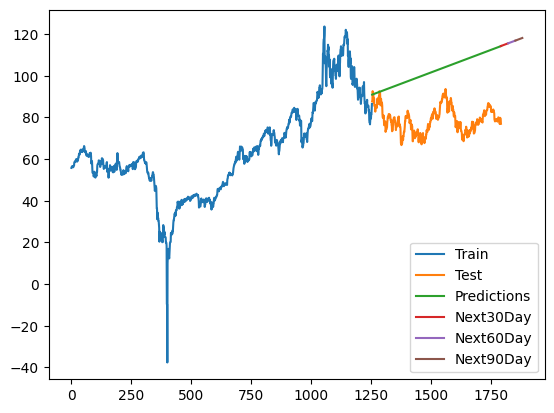

In [357]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Gasoline RBOB

## 7:3

In [358]:
df= pd.read_csv('../dataset/Gasoline RBOB.csv')


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [359]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



C:\Users\21521\AppData\Local\Temp\ipykernel_20340\293547747.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekend_data.loc[len(weekend_data)] = new_row


In [360]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


### Tạo hàm Eval

In [361]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [362]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,1.5356
1,1.553
2,1.5601
3,1.5674
4,1.5743
...,...
1340,2.514
1341,2.509
1342,2.4644
1343,2.4046


### Train, Test


In [363]:
# Split the data into training, testing sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [364]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [365]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [366]:
eval(y_test,y_pred)

** Testing **
MAE:  0.2929558579067549
MAPE:  12.552734655351411
RMSE:  0.3766266200394129


### Predict

In [367]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [368]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[3.02635183 3.027848   3.02934417 3.03084034 3.03233652 3.03383269
 3.03532886 3.03682503 3.03832121 3.03981738 3.04131355 3.04280972
 3.0443059  3.04580207 3.04729824 3.04879441 3.05029059 3.05178676
 3.05328293 3.0547791  3.05627527 3.05777145 3.05926762 3.06076379
 3.06225996 3.06375614 3.06525231 3.06674848 3.06824465 3.06974083]
Predicted closing prices for the next 60 days:
[3.071237   3.07273317 3.07422934 3.07572552 3.07722169 3.07871786
 3.08021403 3.08171021 3.08320638 3.08470255 3.08619872 3.0876949
 3.08919107 3.09068724 3.09218341 3.09367959 3.09517576 3.09667193
 3.0981681  3.09966428 3.10116045 3.10265662 3.10415279 3.10564896
 3.10714514 3.10864131 3.11013748 3.11163365 3.11312983 3.114626  ]
Predicted closing prices for the next 90 days:
[3.11612217 3.11761834 3.11911452 3.12061069 3.12210686 3.12360303
 3.12509921 3.12659538 3.12809155 3.12958772 3.1310839  3.13258007
 3.13407624 3.13557241 3.13706859 3.13856476 3.1400609

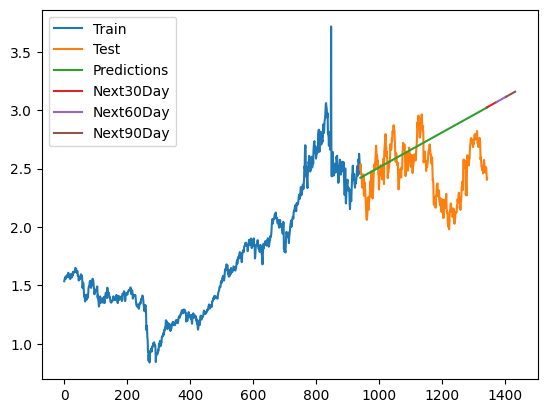

In [369]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Heating Oil

## 7:3

In [370]:
df= pd.read_csv('../dataset/Heating Oil.csv')


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [371]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [372]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1818,2024-05-24 00:00:00,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1819,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1820,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1821,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


### Tạo hàm Eval

In [373]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [374]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,2.001
1,2.00765
2,2.00765
3,2.0143
4,2.0164
...,...
1818,2.4136
1819,2.465
1820,2.437
1821,2.3694


### Train, Test


In [375]:
# Split the data into training, testing sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [376]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [377]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [378]:
eval(y_test,y_pred)

** Testing **
MAE:  0.8706674713130079
MAPE:  32.55665164684702
RMSE:  0.9667368767025559


### Predict

In [379]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [380]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[4.0897119  4.09135386 4.09299582 4.09463777 4.09627973 4.09792169
 4.09956364 4.1012056  4.10284755 4.10448951 4.10613147 4.10777342
 4.10941538 4.11105734 4.11269929 4.11434125 4.1159832  4.11762516
 4.11926712 4.12090907 4.12255103 4.12419299 4.12583494 4.1274769
 4.12911886 4.13076081 4.13240277 4.13404472 4.13568668 4.13732864]
Predicted closing prices for the next 60 days:
[4.13897059 4.14061255 4.14225451 4.14389646 4.14553842 4.14718037
 4.14882233 4.15046429 4.15210624 4.1537482  4.15539016 4.15703211
 4.15867407 4.16031603 4.16195798 4.16359994 4.16524189 4.16688385
 4.16852581 4.17016776 4.17180972 4.17345168 4.17509363 4.17673559
 4.17837755 4.1800195  4.18166146 4.18330341 4.18494537 4.18658733]
Predicted closing prices for the next 90 days:
[4.18822928 4.18987124 4.1915132  4.19315515 4.19479711 4.19643906
 4.19808102 4.19972298 4.20136493 4.20300689 4.20464885 4.2062908
 4.20793276 4.20957472 4.21121667 4.21285863 4.21450058

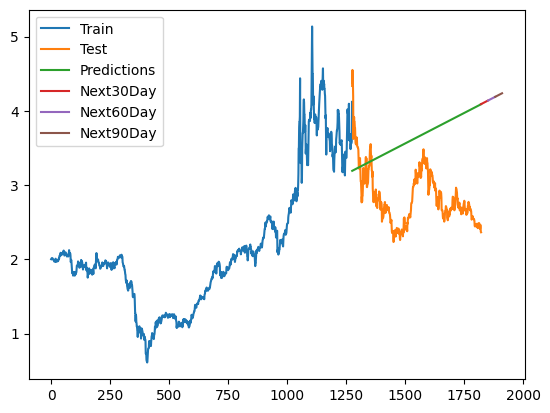

In [381]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Cruide Oil WTI 

## 8:2

In [382]:
df= pd.read_csv('../dataset/Crude Oil WTI.csv')


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [383]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [384]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


### Tạo hàm Eval

In [385]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [386]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,55.8
1,56.195
2,56.195
3,56.59
4,56.56
...,...
1787,77.72
1788,79.83
1789,79.23
1790,77.91


### Train, Test


In [387]:
# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [388]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [389]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [390]:
eval(y_test,y_pred)

** Testing **
MAE:  19.274725857425555
MAPE:  25.08856073576706
RMSE:  20.25049916238668


### Predict

In [391]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [392]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[104.45022413 104.48623193 104.52223973 104.55824753 104.59425532
 104.63026312 104.66627092 104.70227872 104.73828651 104.77429431
 104.81030211 104.84630991 104.8823177  104.9183255  104.9543333
 104.9903411  105.02634889 105.06235669 105.09836449 105.13437229
 105.17038009 105.20638788 105.24239568 105.27840348 105.31441128
 105.35041907 105.38642687 105.42243467 105.45844247 105.49445026]
Predicted closing prices for the next 60 days:
[105.53045806 105.56646586 105.60247366 105.63848145 105.67448925
 105.71049705 105.74650485 105.78251264 105.81852044 105.85452824
 105.89053604 105.92654383 105.96255163 105.99855943 106.03456723
 106.07057503 106.10658282 106.14259062 106.17859842 106.21460622
 106.25061401 106.28662181 106.32262961 106.35863741 106.3946452
 106.430653   106.4666608  106.5026686  106.53867639 106.57468419]
Predicted closing prices for the next 90 days:
[106.61069199 106.64669979 106.68270758 106.71871538 106.75472318
 

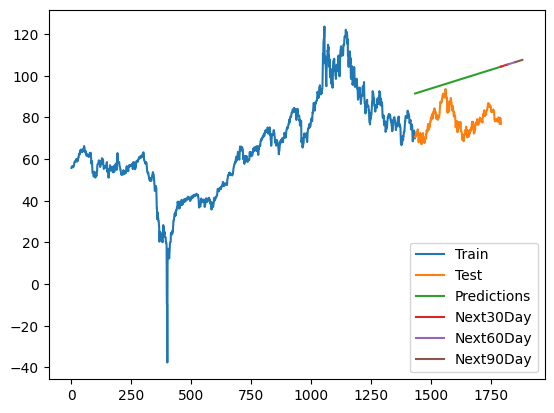

In [393]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Gasoline RBOB

## 8:2

In [394]:
df= pd.read_csv('../dataset/Gasoline RBOB.csv')


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [395]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



C:\Users\21521\AppData\Local\Temp\ipykernel_20340\293547747.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekend_data.loc[len(weekend_data)] = new_row


In [396]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


### Tạo hàm Eval

In [397]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [398]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,1.5356
1,1.553
2,1.5601
3,1.5674
4,1.5743
...,...
1340,2.514
1341,2.509
1342,2.4644
1343,2.4046


### Train, Test


In [399]:
# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [400]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [401]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [402]:
eval(y_test,y_pred)

** Testing **
MAE:  0.36187961273150016
MAPE:  15.618024788865892
RMSE:  0.4332705506360717


### Predict

In [403]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [404]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[3.00499453 3.00647004 3.00794555 3.00942106 3.01089657 3.01237208
 3.01384758 3.01532309 3.0167986  3.01827411 3.01974962 3.02122513
 3.02270063 3.02417614 3.02565165 3.02712716 3.02860267 3.03007818
 3.03155368 3.03302919 3.0345047  3.03598021 3.03745572 3.03893123
 3.04040673 3.04188224 3.04335775 3.04483326 3.04630877 3.04778428]
Predicted closing prices for the next 60 days:
[3.04925978 3.05073529 3.0522108  3.05368631 3.05516182 3.05663733
 3.05811283 3.05958834 3.06106385 3.06253936 3.06401487 3.06549038
 3.06696588 3.06844139 3.0699169  3.07139241 3.07286792 3.07434343
 3.07581893 3.07729444 3.07876995 3.08024546 3.08172097 3.08319648
 3.08467198 3.08614749 3.087623   3.08909851 3.09057402 3.09204953]
Predicted closing prices for the next 90 days:
[3.09352503 3.09500054 3.09647605 3.09795156 3.09942707 3.10090258
 3.10237808 3.10385359 3.1053291  3.10680461 3.10828012 3.10975562
 3.11123113 3.11270664 3.11418215 3.11565766 3.117133

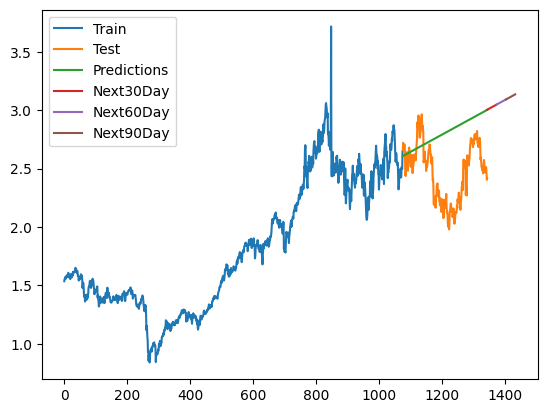

In [405]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Heating Oil

## 8:2

In [406]:
df= pd.read_csv('../dataset/Heating Oil.csv')


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [407]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [408]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1818,2024-05-24 00:00:00,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1819,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1820,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1821,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


### Tạo hàm Eval

In [409]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [410]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,2.001
1,2.00765
2,2.00765
3,2.0143
4,2.0164
...,...
1818,2.4136
1819,2.465
1820,2.437
1821,2.3694


### Train, Test


In [411]:
# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [412]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [413]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [414]:
eval(y_test,y_pred)

** Testing **
MAE:  0.8378643856950092
MAPE:  31.865504241662645
RMSE:  0.9041479142043899


### Predict

In [415]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [416]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[3.85590631 3.85737431 3.85884231 3.86031031 3.86177831 3.86324631
 3.86471432 3.86618232 3.86765032 3.86911832 3.87058632 3.87205432
 3.87352232 3.87499033 3.87645833 3.87792633 3.87939433 3.88086233
 3.88233033 3.88379833 3.88526634 3.88673434 3.88820234 3.88967034
 3.89113834 3.89260634 3.89407434 3.89554234 3.89701035 3.89847835]
Predicted closing prices for the next 60 days:
[3.89994635 3.90141435 3.90288235 3.90435035 3.90581835 3.90728636
 3.90875436 3.91022236 3.91169036 3.91315836 3.91462636 3.91609436
 3.91756237 3.91903037 3.92049837 3.92196637 3.92343437 3.92490237
 3.92637037 3.92783838 3.92930638 3.93077438 3.93224238 3.93371038
 3.93517838 3.93664638 3.93811438 3.93958239 3.94105039 3.94251839]
Predicted closing prices for the next 90 days:
[3.94398639 3.94545439 3.94692239 3.94839039 3.9498584  3.9513264
 3.9527944  3.9542624  3.9557304  3.9571984  3.9586664  3.96013441
 3.96160241 3.96307041 3.96453841 3.96600641 3.9674744

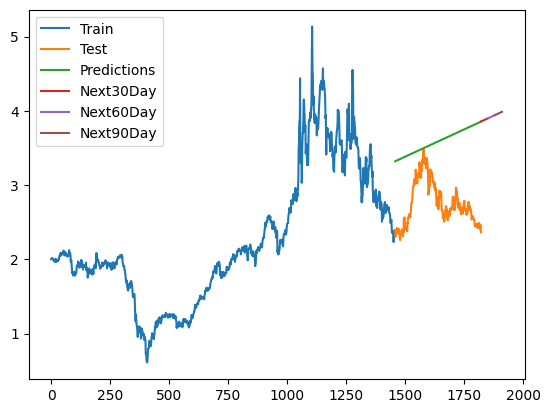

In [417]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Cruide Oil WTI 

## 9:1

In [418]:
df= pd.read_csv('../dataset/Crude Oil WTI.csv')


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [419]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [420]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400.0,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400.0,-0.05
...,...,...,...,...,...,...,...
1787,2024-05-24 00:00:00,77.72,77.04,78.05,76.15,299080.0,1.11
1788,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070.0,1.5
1789,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589.0,-0.75
1790,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780.0,-1.67


### Tạo hàm Eval

In [421]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [422]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,55.8
1,56.195
2,56.195
3,56.59
4,56.56
...,...
1787,77.72
1788,79.83
1789,79.23
1790,77.91


### Train, Test


In [423]:
# Split the data into training, testing sets
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [424]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [425]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [426]:
eval(y_test,y_pred)

** Testing **
MAE:  16.725008540469297
MAPE:  21.782366347056655
RMSE:  17.07205687636474


### Predict

In [427]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [428]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[97.33956204 97.37007153 97.40058102 97.43109051 97.46160001 97.4921095
 97.52261899 97.55312848 97.58363798 97.61414747 97.64465696 97.67516645
 97.70567594 97.73618544 97.76669493 97.79720442 97.82771391 97.85822341
 97.8887329  97.91924239 97.94975188 97.98026138 98.01077087 98.04128036
 98.07178985 98.10229934 98.13280884 98.16331833 98.19382782 98.22433731]
Predicted closing prices for the next 60 days:
[98.25484681 98.2853563  98.31586579 98.34637528 98.37688478 98.40739427
 98.43790376 98.46841325 98.49892274 98.52943224 98.55994173 98.59045122
 98.62096071 98.65147021 98.6819797  98.71248919 98.74299868 98.77350818
 98.80401767 98.83452716 98.86503665 98.89554614 98.92605564 98.95656513
 98.98707462 99.01758411 99.04809361 99.0786031  99.10911259 99.13962208]
Predicted closing prices for the next 90 days:
[ 99.17013157  99.20064107  99.23115056  99.26166005  99.29216954
  99.32267904  99.35318853  99.38369802  99.41420751  99.44471

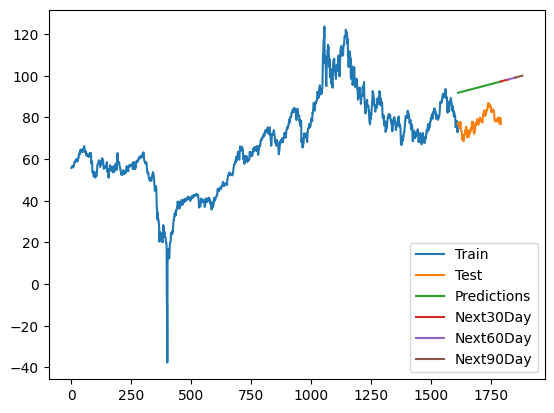

In [429]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Gasoline RBOB

## 9:1

In [430]:
df= pd.read_csv('../dataset/Gasoline RBOB.csv')


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [431]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



C:\Users\21521\AppData\Local\Temp\ipykernel_20340\293547747.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekend_data.loc[len(weekend_data)] = new_row


In [432]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


### Tạo hàm Eval

In [433]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [434]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,1.5356
1,1.553
2,1.5601
3,1.5674
4,1.5743
...,...
1340,2.514
1341,2.509
1342,2.4644
1343,2.4046


### Train, Test


In [435]:
# Split the data into training, testing sets
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [436]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [437]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [438]:
eval(y_test,y_pred)

** Testing **
MAE:  0.4028229115913031
MAPE:  17.710526029474806
RMSE:  0.45386822587847697


### Predict

In [439]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [440]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[2.91759691 2.91898043 2.92036395 2.92174747 2.92313098 2.9245145
 2.92589802 2.92728154 2.92866505 2.93004857 2.93143209 2.93281561
 2.93419912 2.93558264 2.93696616 2.93834968 2.93973319 2.94111671
 2.94250023 2.94388375 2.94526726 2.94665078 2.9480343  2.94941782
 2.95080133 2.95218485 2.95356837 2.95495189 2.9563354  2.95771892]
Predicted closing prices for the next 60 days:
[2.95910244 2.96048596 2.96186947 2.96325299 2.96463651 2.96602003
 2.96740354 2.96878706 2.97017058 2.9715541  2.97293761 2.97432113
 2.97570465 2.97708816 2.97847168 2.9798552  2.98123872 2.98262223
 2.98400575 2.98538927 2.98677279 2.9881563  2.98953982 2.99092334
 2.99230686 2.99369037 2.99507389 2.99645741 2.99784093 2.99922444]
Predicted closing prices for the next 90 days:
[3.00060796 3.00199148 3.003375   3.00475851 3.00614203 3.00752555
 3.00890907 3.01029258 3.0116761  3.01305962 3.01444314 3.01582665
 3.01721017 3.01859369 3.01997721 3.02136072 3.0227442

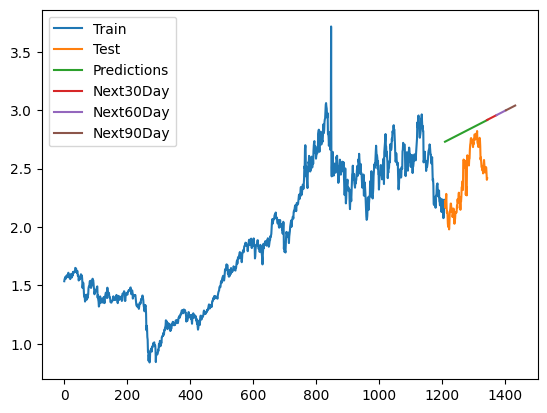

In [441]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Heating Oil

## 9:1

In [442]:
df= pd.read_csv('../dataset/Heating Oil.csv')


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [443]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [444]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1818,2024-05-24 00:00:00,2.4136,2.4175,2.4302,2.3897,21870.0,0.07
1819,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1820,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1821,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


### Tạo hàm Eval

In [445]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [446]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,2.001
1,2.00765
2,2.00765
3,2.0143
4,2.0164
...,...
1818,2.4136
1819,2.465
1820,2.437
1821,2.3694


### Train, Test


In [447]:
# Split the data into training, testing sets
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [448]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [449]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [450]:
eval(y_test,y_pred)

** Testing **
MAE:  0.8061115523634261
MAPE:  30.77015797250236
RMSE:  0.825016586904357


### Predict

In [451]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [452]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[3.5741479  3.57540217 3.57665644 3.57791071 3.57916498 3.58041925
 3.58167352 3.58292779 3.58418206 3.58543634 3.58669061 3.58794488
 3.58919915 3.59045342 3.59170769 3.59296196 3.59421623 3.5954705
 3.59672477 3.59797904 3.59923331 3.60048758 3.60174185 3.60299612
 3.6042504  3.60550467 3.60675894 3.60801321 3.60926748 3.61052175]
Predicted closing prices for the next 60 days:
[3.61177602 3.61303029 3.61428456 3.61553883 3.6167931  3.61804737
 3.61930164 3.62055591 3.62181019 3.62306446 3.62431873 3.625573
 3.62682727 3.62808154 3.62933581 3.63059008 3.63184435 3.63309862
 3.63435289 3.63560716 3.63686143 3.6381157  3.63936998 3.64062425
 3.64187852 3.64313279 3.64438706 3.64564133 3.6468956  3.64814987]
Predicted closing prices for the next 90 days:
[3.64940414 3.65065841 3.65191268 3.65316695 3.65442122 3.65567549
 3.65692976 3.65818404 3.65943831 3.66069258 3.66194685 3.66320112
 3.66445539 3.66570966 3.66696393 3.6682182  3.66947247 

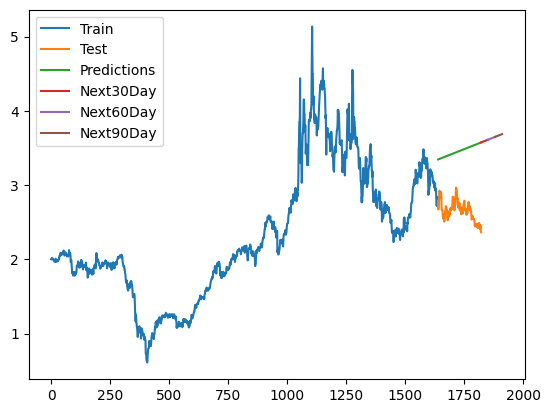

In [453]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()